In [48]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [49]:
trainPath = "/mnt/b405f74a-72c4-4e5a-8bd4-d763618331be/flower_data/train"
validationPath = "/mnt/b405f74a-72c4-4e5a-8bd4-d763618331be/flower_data/valid"

sizeOne = 256
sizeTwo = (224, 224)


traintransform = transforms.Compose([
    transforms.Resize(sizeOne),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

validationtransform = transforms.Compose([
    transforms.Resize(sizeTwo),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    #transforms.RandomCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainData = torchvision.datasets.ImageFolder(trainPath, transform=traintransform)

validationData = torchvision.datasets.ImageFolder(validationPath, transform=validationtransform)

In [50]:
batchSize = 64

traindataLoader = torch.utils.data.DataLoader(trainData,
                                          batch_size=batchSize,
                                          shuffle=True)

validationdataLoader = torch.utils.data.DataLoader(validationData, batch_size=batchSize)

In [51]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

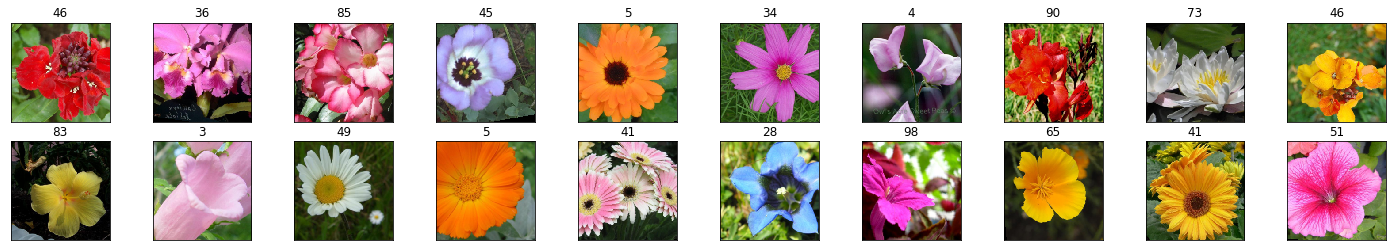

In [52]:
# obtain one batch of training images
traindataiter = iter(traindataLoader)
images, labels = traindataiter.next()
images = images.numpy()
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(trainData.classes[labels[idx]])

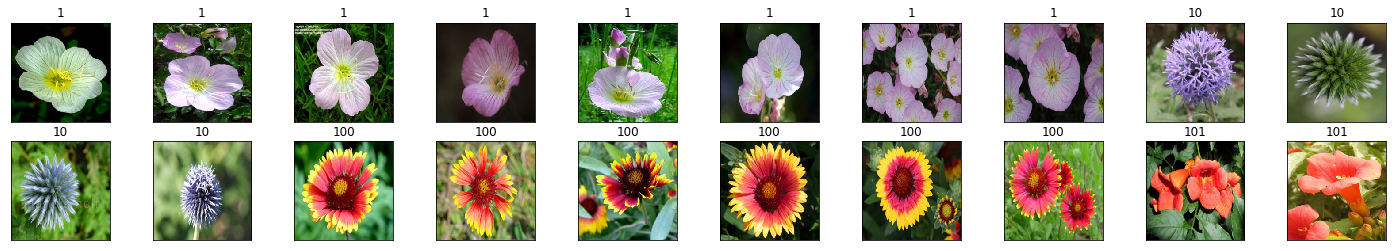

In [53]:
# obtain one batch of training images
validationdataiter = iter(validationdataLoader)
images, labels = validationdataiter.next()
images = images.numpy()
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(validationData.classes[labels[idx]])

In [54]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [55]:
for param in model.parameters():
    param.requires_grad = False

In [56]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(512, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

In [57]:
model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

In [58]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in traindataLoader:
        steps += 1
        
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            accuracy = 0
            
            for images, labels in validationdataLoader:
                
                images, labels = images.cuda(), labels.cuda()
                
                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss.item()
                
                ps = torch.exp(logps)
                top_ps, top_class = ps.topk(1, dim=1)
                equality = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validationdataLoader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validationdataLoader):.3f}")
            
            running_loss = 0
            model.train()
        
        
        
# Epoch 4/5.. Train loss: 0.580.. Test loss: 0.488.. Test accuracy: 0.882
# without random horizontal flip and random rotation
# with batch size 64, resnet50

# Epoch 5/5.. Train loss: 0.713.. Test loss: 0.629.. Test accuracy: 0.842
# with random horizontal flip and random rotation
# with batch size 64, resnet50

        

Epoch 1/5.. Train loss: 5.513.. Test loss: 4.847.. Test accuracy: 0.034
Epoch 1/5.. Train loss: 4.678.. Test loss: 4.403.. Test accuracy: 0.055
Epoch 1/5.. Train loss: 4.447.. Test loss: 4.292.. Test accuracy: 0.085
Epoch 1/5.. Train loss: 4.307.. Test loss: 4.142.. Test accuracy: 0.149
Epoch 1/5.. Train loss: 4.149.. Test loss: 3.975.. Test accuracy: 0.158
Epoch 1/5.. Train loss: 3.940.. Test loss: 3.700.. Test accuracy: 0.177
Epoch 1/5.. Train loss: 3.658.. Test loss: 3.470.. Test accuracy: 0.213
Epoch 1/5.. Train loss: 3.475.. Test loss: 3.189.. Test accuracy: 0.299
Epoch 1/5.. Train loss: 3.135.. Test loss: 2.995.. Test accuracy: 0.329
Epoch 1/5.. Train loss: 3.230.. Test loss: 2.767.. Test accuracy: 0.355
Epoch 1/5.. Train loss: 2.896.. Test loss: 2.599.. Test accuracy: 0.405
Epoch 1/5.. Train loss: 2.822.. Test loss: 2.423.. Test accuracy: 0.426
Epoch 1/5.. Train loss: 2.661.. Test loss: 2.242.. Test accuracy: 0.506
Epoch 1/5.. Train loss: 2.545.. Test loss: 2.238.. Test accuracy